### Importing modules

In [1]:
# Importing modules
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from math import cos, asin, sqrt, pi
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import folium
from folium import plugins

#### Settings

In [2]:
pd.options.display.max_colwidth = 150
pd.options.display.precision = 3
%matplotlib inline

## Bike sharing analysis

### Main analysis goals 
<ul>
<li>Identify active and inactive stations
<li>Identify the most used stations
<li>Identify stations with bikes excess and bikes shortage
<li>Visualize geographic locations of the stations
<li>Calculate distances between individual stations
<li>Analyze durations of trips, their central tendencies and outliers.

## Import data to dataframes<br>
Parse column "started_at" and "ended_at" as a datetime type so we are goint to be able to work with datetime format in future analysis.

In [3]:
df = pd.read_csv("edinburgh_bikes.csv", index_col="index",parse_dates=["started_at","ended_at"])
df_weather = pd.read_csv("edinburgh_weather.csv",index_col=0,parse_dates=["date"])

### Exploring first dataset (edinburgh_bikes)

In [4]:
# Exploring first couple rows
df.head()

started_at            ended_at  duration  start_station_id  \
index                                                                       
0     2018-09-15 08:52:05 2018-09-15 09:11:48      1182               247   
1     2018-09-15 09:24:33 2018-09-15 09:41:09       995               259   
2     2018-09-15 09:48:54 2018-09-15 10:46:40      3466               262   
3     2018-09-16 12:01:36 2018-09-16 12:25:26      1430               255   
4     2018-09-16 12:03:43 2018-09-16 12:11:16       452               255   

      start_station_name         start_station_description  \
index                                                        
0       Charlotte Square  North Corner of Charlotte Square   
1       St Andrew Square                 North East corner   
2             Canonmills                      near Tesco's   
3      Kings Buildings 4                          X-Y Cafe   
4      Kings Buildings 4                          X-Y Cafe   

       start_station_latitude  start_station_longitude  end_station_id  \
index                                                                    
0                      55.952                   -3.207             259   
1                      55.955                   -3.193             262   
2                      55.963                   -3.196             250   
3                      55.922                   -3.177             254   
4                      55.922                   -3.177             253   

       end_station_name                 end_station_description  \
index                                                             
0      St Andrew Square                       North East corner   
1            Canonmills                            near Tesco's   
2         Victoria Quay  Entrance to Scottish Government Office   
3      Kings Building 3                    Kings Building House   
4      Kings Building 2                      Sanderson Building   

       end_station_latitude  end_station_longitude  
index                                               
0                    55.955                 -3.193  
1                    55.963                 -3.196  
2                    55.978                 -3.174  
3                    55.923                 -3.175  
4                    55.923                 -3.172

In [5]:
# Getting information about timespan of dataset 
first_transaction = df['started_at'].min()
last_transaction = df['started_at'].max()
print(last_transaction - first_transaction)
print("First record:",first_transaction)
print("Last record:",last_transaction)

1019 days 15:06:28
First record: 2018-09-15 08:52:05
Last record: 2021-06-30 23:58:33


#### Variables

The dataset has 13 columns and 438259 records.<br>

First record is from 15.9.2018 and last record is from 30.6.2021.<br>

Dataset have 2 datetime variables, 7 numerical variable and 4 text variables
<ul>
<li> started_at - datetime field when trip started
<li> ended_at - datetime field when trip ended 
<li> duration - duration of trips in seconds         
<li> start_station_id - identification number of station where trip begun 
<li> start_station_name - text name of start station     
<li> start_station_description - more detail description of starting station
<li> start_station_latitude - float number of latitude where trip begun
<li> start_station_longitude - float number of longitude where trip begun
<li> end_station_id - identification number of station where trip ended   
<li> end_station_name - text name of end station   
<li> end_station_description - more detail description of ending station
<li> end_station_latitude - float number of latitude where trip ended     
<li> end_station_longitude - float number of longitude where trip ended

In [6]:
# Structure and datatypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438259 entries, 0 to 12640
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   started_at                 438259 non-null  datetime64[ns]
 1   ended_at                   438259 non-null  datetime64[ns]
 2   duration                   438259 non-null  int64         
 3   start_station_id           438259 non-null  int64         
 4   start_station_name         438259 non-null  object        
 5   start_station_description  434118 non-null  object        
 6   start_station_latitude     438259 non-null  float64       
 7   start_station_longitude    438259 non-null  float64       
 8   end_station_id             438259 non-null  int64         
 9   end_station_name           438259 non-null  object        
 10  end_station_description    433570 non-null  object        
 11  end_station_latitude       438259 non-null  float64  

#### Checking for missing values<br>
Only missing values are in columns for description of station. These variables are not criticly important for our analysis. So we can leave thes values empty. Other than that dataset seems to be complete.

In [7]:
# Checking for missing values
df.isna().any()

started_at                   False
ended_at                     False
duration                     False
start_station_id             False
start_station_name           False
start_station_description     True
start_station_latitude       False
start_station_longitude      False
end_station_id               False
end_station_name             False
end_station_description       True
end_station_latitude         False
end_station_longitude        False
dtype: bool

In [8]:
df.isna().sum()

started_at                      0
ended_at                        0
duration                        0
start_station_id                0
start_station_name              0
start_station_description    4141
start_station_latitude          0
start_station_longitude         0
end_station_id                  0
end_station_name                0
end_station_description      4689
end_station_latitude            0
end_station_longitude           0
dtype: int64

#### Chceking duplicated values 
Dataset has 1163 duplicate rows. So we drop duplicate rows so the dataset is cleaner.<br>

In [9]:
# Checking for duplicated values
df.duplicated().sum()

1163

In [10]:
# Exploring duplicated rows
df[df.duplicated(keep=False)]

started_at            ended_at  duration  start_station_id  \
index                                                                       
1683  2019-03-11 23:53:39 2019-03-12 00:20:27      1608               249   
1684  2019-03-11 23:53:39 2019-03-12 00:20:27      1608               249   
1685  2019-03-11 23:57:31 2019-03-12 00:04:49       437               171   
1686  2019-03-11 23:57:31 2019-03-12 00:04:49       437               171   
1687  2019-03-12 00:05:14 2019-03-12 00:12:49       454               189   
...                   ...                 ...       ...               ...   
8488  2021-05-21 22:32:33 2021-05-21 22:49:49      1035               251   
10582 2021-05-27 18:40:46 2021-05-27 19:43:17      3751              1807   
10583 2021-05-27 18:40:46 2021-05-27 19:43:17      3751              1807   
7201  2021-06-16 20:11:22 2021-06-16 20:27:46       983               289   
7202  2021-06-16 20:11:22 2021-06-16 20:27:46       983               289   

      start_station_name  \
index                      
1683      Fountainbridge   
1684      Fountainbridge   
1685       George Square   
1686       George Square   
1687       City Chambers   
...                  ...   
8488    Waverley Station   
10582  Gamekeeper's Road   
10583  Gamekeeper's Road   
7201       Castle Street   
7202       Castle Street   

                                      start_station_description  \
index                                                             
1683                       Fountainbridge by Gardner's Crescent   
1684                       Fountainbridge by Gardner's Crescent   
1685   George Square, south side in front of University library   
1686   George Square, south side in front of University library   
1687                                   City Chambers Quadrangle   
...                                                         ...   
8488                       Platform level near Calton Road Exit   
10582                             Junction with Whitehouse Road   
10583                             Junction with Whitehouse Road   
7201                                           Near Rose Street   
7202                                           Near Rose Street   

       start_station_latitude  start_station_longitude  end_station_id  \
index                                                                    
1683                   55.943                   -3.209             249   
1684                   55.943                   -3.209             249   
1685                   55.943                   -3.188             290   
1686                   55.943                   -3.188             290   
1687                   55.950                   -3.190             340   
...                       ...                      ...             ...   
8488                   55.953                   -3.188            1025   
10582                  55.969                   -3.307            1770   
10583                  55.969                   -3.307            1770   
7201                   55.952                   -3.203             256   
7202                   55.952                   -3.203             256   

       end_station_name                              end_station_description  \
index                                                                          
1683     Fountainbridge                 Fountainbridge by Gardner's Crescent   
1684     Fountainbridge                 Fountainbridge by Gardner's Crescent   
1685        Bruntsfield  Corner of Bruntsfield Terrace and Bruntsfield Place   
1686        Bruntsfield  Corner of Bruntsfield Terrace and Bruntsfield Place   
1687       Meadow Place            Corner of Meadow Place and Melville Drive   
...                 ...                                                  ...   
8488     Dundee Terrace             Corner of Dundee Street & Dundee Terrace   
10582     Ellersly Road  Corner with A8 Corstorphine Road at Western Terrace   
10583     Ell

In [11]:
# Drop duplicated records
df.drop_duplicates(inplace=True)

Then we have couple instances of stations that has same id but different names. To find out which name is correct is out of scope of this analysis and it doesn't hinder our analysis. For further aggregations we are going to use only station ids.

In [12]:
# Get stations with same id but different name 
misnamed_stations = df.groupby(["start_station_id","start_station_name"]).agg(cnd = ("start_station_id", "count")).reset_index()
misnamed_stations[misnamed_stations["start_station_id"].duplicated(keep=False)]

start_station_id                                      start_station_name  \
20                261                                         Brunswick Place   
21                261                               Brunswick Place - Virtual   
33                290                                             Bruntsfield   
34                290                                       Bruntsfield links   
58                366                                          Dudley Gardens   
59                366                          Newhaven Road / Dudley Gardens   
71                870                                       Hillside Crescent   
72                870                                     Hillside Crescent 2   
95                965                     Haymarket - Murrayfield Rugby Event   
96                965                             Sustrans - walk cycle event   
98                981  RHC - Edinburgh Festival Camping (05th to 26th August)   
99                981     Royal Highland Show - West Gate (19th to 23rd June)   
105              1024                                            Meadow Place   
106              1024                                          Meadow Place 2   
110              1028                                           Hunter Square   
111              1028                                                The Tron   
205              2268                                            Picady Place   
206              2268                                           Picardy Place   

       cnd  
20    2404  
21     457  
33    2057  
34    1236  
58    1684  
59     175  
71     597  
72     328  
95      19  
96       4  
98      41  
99       1  
105  11286  
106     87  
110   2558  
111    613  
205      1  
206   1928

Looking at descriptive statistics does not give us much information.

In [13]:
df.describe()

duration  start_station_id  start_station_latitude  \
count  4.371e+05        437096.000              437096.000   
mean   1.949e+03           924.936                  55.951   
std    5.663e+03           670.132                   0.014   
min    6.100e+01           171.000                  55.908   
25%    6.240e+02           260.000                  55.940   
50%    1.164e+03          1019.000                  55.948   
75%    2.529e+03          1728.000                  55.959   
max    2.363e+06          2268.000                  55.993   

       start_station_longitude  end_station_id  end_station_latitude  \
count               437096.000      437096.000            437096.000   
mean                    -3.197         970.108                55.953   
std                      0.039         676.792                 0.016   
min                     -3.407         171.000                53.396   
25%                     -3.208         262.000                55.942   
50%                     -3.192        1024.000                55.952   
75%                     -3.181        1737.000                55.963   
max                     -3.058        2268.000                55.993   

       end_station_longitude  
count             437096.000  
mean                  -3.195  
std                    0.042  
min                   -3.407  
25%                   -3.208  
50%                   -3.192  
75%                   -3.176  
max                   -2.990

### Analysing bike stations
**Number of unique stations** <br>
We have 198 unique stations from where the rides began and 199 unique stations where the rides ended.<br>
Every station was used at least one time.

In [14]:
df["start_station_id"].nunique() , df["end_station_id"].nunique()

(198, 199)

#### Active / Inactive bike stations
Active stations are define as stations that **were used** at least one time during year 2021 (last 6 month of data)<br>
Inactive stations are define as stations that **were not** used at least one time during year 2021 (last 6 month of data)<br>

There are **98 active stations** that were used in last 6 month.<br>
There are **100 inactive stations** that were used in last 6 month.

In [15]:
first_record = df.sort_values("started_at").iloc[0,0]
last_record = df.sort_values("started_at",ascending=False).iloc[0,0]

print("First record in dataset:",first_record)
print("Last record in dataset:",last_record)
print("Duration of dataset",first_record - last_record)

First record in dataset: 2018-09-15 08:52:05
Last record in dataset: 2021-06-30 23:58:33
Duration of dataset -1020 days +08:53:32


In [16]:
last_date_of_use = df[["start_station_id","started_at"]].sort_values(by="started_at").drop_duplicates(subset=["start_station_id"],keep="last")
inactive_stations = last_date_of_use[last_date_of_use["started_at"].dt.year < 2021]["start_station_id"].tolist()
active_stations = last_date_of_use[last_date_of_use["started_at"].dt.year >= 2021]["start_station_id"].tolist()

print("Number of active stations:", len(active_stations),"\n","Active stations:",active_stations,"\n")
print("Number of unactive stations:", len(inactive_stations),"\n","Inactive stations:",inactive_stations)

Number of active stations: 98 
 Active stations: [1864, 1865, 1860, 1871, 1874, 1869, 1868, 1866, 1870, 1877, 1042, 1809, 1770, 252, 1820, 1815, 1749, 1822, 1093, 1753, 1807, 1726, 1758, 225, 1097, 1098, 246, 1051, 349, 2265, 1028, 262, 254, 1756, 253, 2259, 296, 250, 1737, 1102, 1019, 1731, 260, 1722, 1819, 251, 1748, 1050, 1025, 1813, 1821, 1721, 1767, 1818, 1798, 1739, 1728, 1017, 358, 1745, 1757, 248, 1092, 1769, 259, 1725, 171, 264, 258, 1729, 1738, 1765, 1754, 1039, 1824, 1768, 1823, 265, 189, 1730, 1096, 1720, 2268, 1052, 2263, 1763, 249, 1744, 1038, 289, 1727, 1091, 183, 1024, 1090, 1814, 256, 247] 

Number of unactive stations: 100 
 Inactive stations: [267, 241, 266, 353, 365, 284, 297, 901, 883, 869, 875, 871, 867, 878, 872, 891, 864, 343, 275, 342, 351, 277, 863, 880, 350, 354, 273, 964, 982, 980, 991, 255, 888, 352, 340, 820, 299, 1018, 1032, 965, 981, 1027, 882, 341, 887, 870, 1056, 1057, 1094, 344, 366, 879, 890, 874, 257, 862, 868, 881, 860, 347, 359, 356, 357, 885, 355

### Frequency of station usage

We define usage of station if people use the stations either as a starting station or even as a ending station.

In [17]:
# Count of instances when the station was used
start_stations_frequency = df["start_station_id"].value_counts()
end_stations_frequency = df["end_station_id"].value_counts()

In [18]:
stations_frequency = start_stations_frequency.to_frame(name="start_station_frequency").join(end_stations_frequency.to_frame(name="end_station_frequency"))
stations_frequency["difference"] = stations_frequency["end_station_frequency"]-stations_frequency["start_station_frequency"]
stations_frequency.reset_index(inplace=True)
stations_frequency.rename(columns={"index":"station_id"},inplace=True)

Below we got stations where users most frequently starting their trips.

In [19]:
stations_frequency.sort_values(by="start_station_frequency",ascending=False).head(10)

station_id  start_station_frequency  end_station_frequency  difference
0         265                    17351                15183.0     -2168.0
1         248                    12793                 7868.0     -4925.0
2         259                    12197                 8336.0     -3861.0
3        1728                    11843                16656.0      4813.0
4        1024                    11373                 8792.0     -2581.0
5         250                    10658                15218.0      4560.0
6         262                     9509                11906.0      2397.0
7         264                     9414                 6617.0     -2797.0
8         289                     8861                 7385.0     -1476.0
9         183                     8507                 8377.0      -130.0

Below we got stations where users most frequently ending their trips.

In [20]:
stations_frequency.sort_values(by="end_station_frequency",ascending=False).head(10)

station_id  start_station_frequency  end_station_frequency  difference
3         1728                    11843                16656.0      4813.0
5          250                    10658                15218.0      4560.0
0          265                    17351                15183.0     -2168.0
6          262                     9509                11906.0      2397.0
13        1824                     7281                11243.0      3962.0
12         358                     7941                10987.0      3046.0
4         1024                    11373                 8792.0     -2581.0
9          183                     8507                 8377.0      -130.0
2          259                    12197                 8336.0     -3861.0
18         258                     6210                 8195.0      1985.0

### Bike shortage and excess  
We are trying to identify stations with bike excess and bike shortage. Stations with bike excess are define as stations where more trips ended than started and station with bike shortage are define as stations where more trips started then ended.<br/>

There are 83 stations that could have potential bike shortage. 

In [21]:
# Stations with negative difference
stations_frequency[stations_frequency["difference"] < 0]["station_id"].count()

83

Below we plot stations that have negative difference greater than 1000. That get us 16 stations with pretty large potential shortage of bikes. The station with the greatest potential shortage of bikes is station with id 248 and has almost 5000 negative difference of bikes taken and returned. 

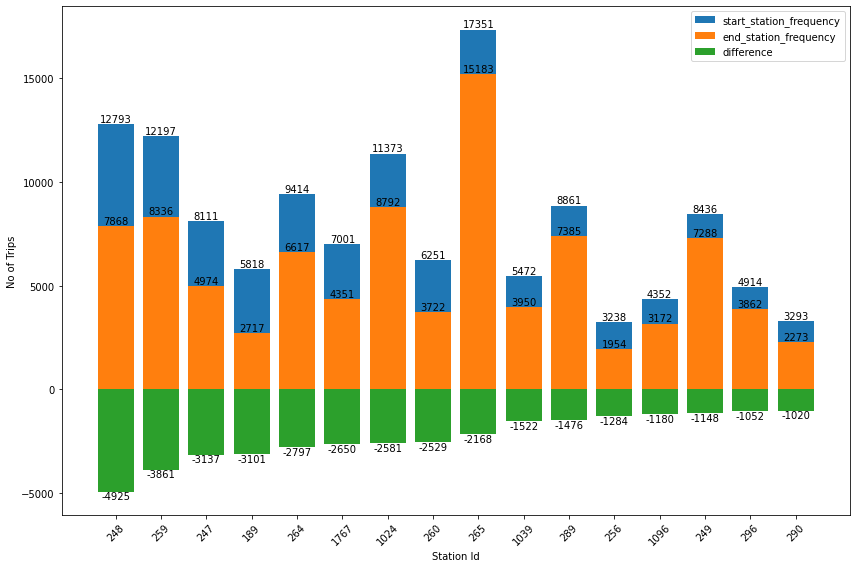

In [22]:
# Ploting stations with bike shortage
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

data = stations_frequency[stations_frequency["difference"] < -1000].sort_values(by='difference')
labels = data["station_id"]
x = np.arange(len(labels))

ax1 = ax.bar(x,height=data["start_station_frequency"],label="start_station_frequency")
ax2 = ax.bar(x,height=data["end_station_frequency"],label="end_station_frequency")
ax3 = ax.bar(x,height=data["difference"],label="difference")

ax.set_xticks(x, labels,rotation=45)
ax.set_xlabel("Station Id")
ax.set_ylabel("No of Trips")

ax.bar_label(ax1)
ax.bar_label(ax2)
ax.bar_label(ax3)
ax.legend()

fig.tight_layout()

There are 112 stations with potential of bike excess.

In [23]:
# Stations with positive difference
stations_frequency[stations_frequency["difference"] > 0]["station_id"].count()

112

Plotting stations with positive difference greater than 1000 give us 11 stations with pretty large possibility of bike excess. Station with id 1728 has the highest excess of bikes with almost 5000 difference of bikes returnd to taken.

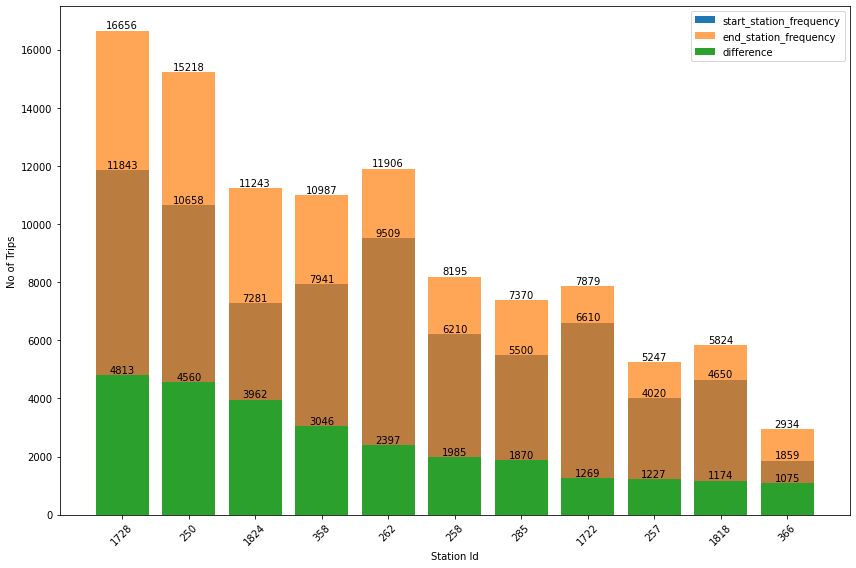

In [24]:
# Ploting stations with bike excess
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

data = stations_frequency[stations_frequency["difference"] > 1000].sort_values(by='difference',ascending=False)
labels = data["station_id"]
x = np.arange(len(labels))

ax1 = ax.bar(x,height=data["start_station_frequency"],label="start_station_frequency")
ax2 = ax.bar(x,height=data["end_station_frequency"],label="end_station_frequency",alpha=0.7)
ax3 = ax.bar(x,height=data["difference"],label="difference")

ax.set_xticks(x, labels,rotation=45)
ax.set_xlabel("Station Id")
ax.set_ylabel("No of Trips")

ax.bar_label(ax1)
ax.bar_label(ax2)
ax.bar_label(ax3)
ax.legend()

fig.tight_layout()

### Visualizing stations

In [25]:
location_df = df[["start_station_id","start_station_name","start_station_latitude","start_station_longitude"]].drop_duplicates(subset=["start_station_id"])

In [26]:
location_df = location_df.merge(stations_frequency,left_on="start_station_id",right_on="station_id")
location_df.drop(columns=["station_id"], inplace=True)
location_df.rename(columns={"start_station_id_y":"cnt"},inplace=True)
location_df["difference"] = location_df["end_station_frequency"] - location_df["start_station_frequency"]
location_df

start_station_id        start_station_name  start_station_latitude  \
0                 247          Charlotte Square                  55.952   
1                 259          St Andrew Square                  55.955   
2                 262                Canonmills                  55.963   
3                 255         Kings Buildings 4                  55.922   
4                 253          Kings Building 2                  55.923   
..                ...                       ...                     ...   
193              1860     Ingliston Park & Ride                  55.939   
194              2259          Leith Walk North                  55.968   
195              2263          Musselburgh Lidl                  55.944   
196              2265  Musselburgh Brunton Hall                  55.944   
197              2268              Picady Place                  55.957   

     start_station_longitude  start_station_frequency  end_station_frequency  \
0                     -3.207                     8111                 4974.0   
1                     -3.193                    12197                 8336.0   
2                     -3.196                     9509                11906.0   
3                     -3.177                      251                  193.0   
4                     -3.172                     4085                 4545.0   
..                       ...                      ...                    ...   
193                   -3.356                      136                  224.0   
194                   -3.174                     1142                 1537.0   
195                   -3.067                      709                  838.0   
196                   -3.058                      294                  379.0   
197                   -3.186                     1929                 1475.0   

     difference  
0       -3137.0  
1       -3861.0  
2        2397.0  
3         -58.0  
4         460.0  
..          ...  
193        88.0  
194       395.0  
195       129.0  
196        85.0  
197      -454.0  

[198 rows x 7 columns]

First visualition show us that frequency of station usage is higher in location that seems to be a city center. Another observation seems to be that stations where users ending their trips are rather close to the center and on the contrary the stations where users starting their trips are farther from the center at the more of a eastern part closer to the water.   

In [27]:
chart =alt.Chart(location_df).mark_circle().encode(
    alt.X('start_station_latitude', scale=alt.Scale(zero=False)),
    alt.Y('start_station_longitude', scale=alt.Scale(zero=False, padding=1)),
    size="start_station_frequency",
    color = "difference",
    tooltip=['start_station_id:N', 'start_station_name:N']
).properties(
    width=600,
    height=400
)
chart

alt.Chart(...)

#### Geographic plot of most used stations

In [28]:
location_df["excess"] = np.where(location_df["difference"] < 0, 0, 1)

In [29]:
m = folium.Map([location_df["start_station_latitude"][0], location_df["start_station_longitude"][0]]);

In [30]:
colors = {0:'red',
        1: 'black'
       }
for i in range(0,len(location_df.index)):
    folium.vector_layers.Circle(
        location=[location_df.iloc[i,2],location_df.iloc[i,3]],
        tooltip = "id: " + str(location_df.iloc[i,0]) + "\n" +  location_df.iloc[i,1],
        fill = True,
        color = colors[location_df.iloc[i,7]],
        radius = 60
    ).add_to(m)

Below we plot stations on the map and differentiate between stations where users are more likely to start trips and stations where they are more likely to end their trips.<br/>

**Red marks** - stations where users started more trips then ended<br/>
**Black marks** - stations where users ended more trips then started<br/>

This contributes to are previous observation that in the city center could be issue with the shortage of bikes in the stations and on more of the periphery locations there could be issue with excess of bikes.

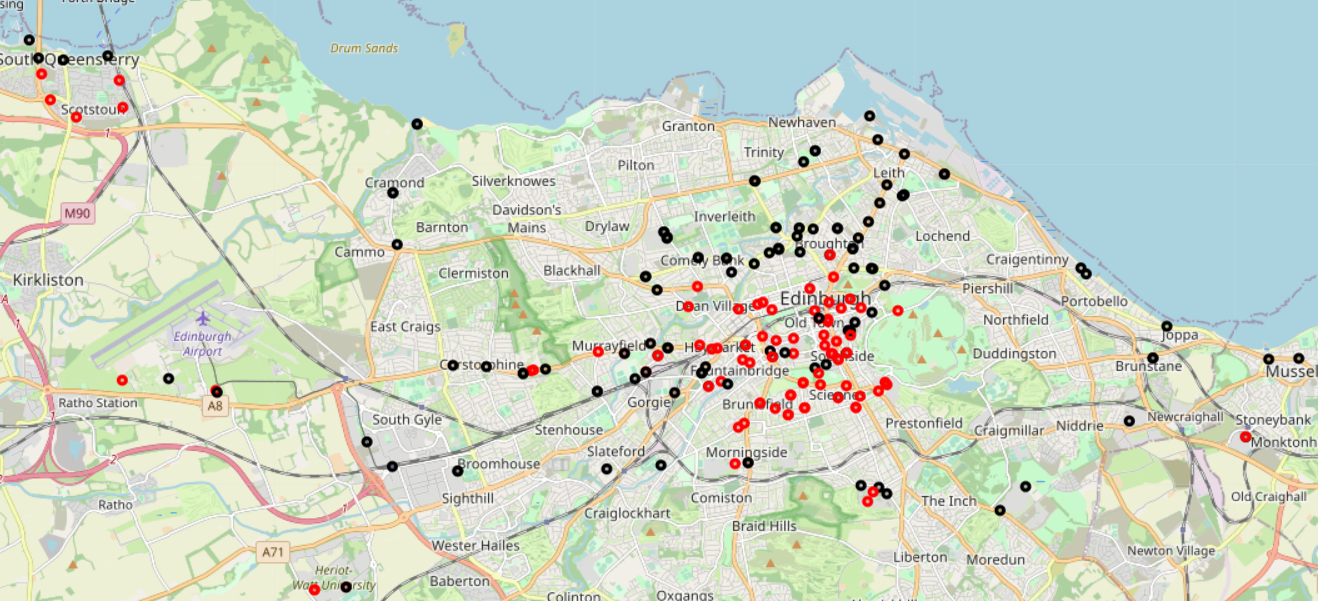

In [31]:
#m

#### Clustering and geographic plot

To cluster individual stations we use method of K-means clustering. We chooded 6 clusters and then plot them to map.

In [32]:
dimensions = ['start_station_latitude','start_station_longitude']
Xs = location_df[dimensions]
kmeans = KMeans(n_clusters=6)
kmeans.fit(Xs)

KMeans(n_clusters=6)

In [33]:
location_df["clusters"] = kmeans.labels_

In [34]:
clusters = {0:[],
        1:[],
        2: [],
        3: [],
        4: [],
        5: []}
for i in range(6):
    BM = kmeans.labels_ == i
    clusters[i].append(location_df[BM].start_station_id.values.tolist())
    print("Cluster {} : {}".format(i,location_df[BM].start_station_id.values))

Cluster 0 : [ 862  873  872  863  874  864  875  871 1040 1723 1724 1722 1725 1747
 1807 1815 1820 1819 1822 1859]
Cluster 1 : [ 259  262  261  250  225  251  266  256  241  273  284  285  357  358
  356  355  354  366  820  868  870  869  867  880  901 1026  299 1032
 1038 1091 1090 1095 1720 1729 1730 1737 1746 1743 1745 1769 1814 1818
 1824 2259 2268]
Cluster 2 : [ 982  980  981 1866 1864 1865 1869 1868 1870 1871 1874 1877 1860]
Cluster 3 : [ 257  297 1033 1041 1056 1728 1739 1758 1800 1813 2263 2265]
Cluster 4 : [ 277  351  353  350  352  349  648  866  887  877  889  885  878  865
  876  883  884  965  964 1025 1055 1093 1092 1102 1738 1740 1749 1752
 1753 1754 1756 1757 1765 1763 1764 1766 1770 1799 1808 1821 1823]
Cluster 5 : [ 247  255  253  252  254  264  246  265  183  189  267  171  248  249
  260  258  275  289  290  296  347  341  343  342  344  345  340  346
  365  359  860  882  888  881  879  891  890  991 1018 1017 1019 1024
 1027 1028 1031 1030 1039 1051 1050 1042 105

In [35]:
m = folium.Map([location_df["start_station_latitude"][0], location_df["start_station_longitude"][0]]);

In [36]:
colors = {0:'blue',
        1: 'green',
        2: 'purple',
        3:  'red',
          4:'black',
          5:'orange'
         }

for i in range(0,len(location_df.index)):
    folium.vector_layers.Circle(
        location=[location_df.iloc[i,2],location_df.iloc[i,3]],
        tooltip = "id: " + str(location_df.iloc[i,0]) + "\n" +  location_df.iloc[i,1],
        fill = True,
        color = colors[location_df.iloc[i,8]]
    ).add_to(m)

Map with stations divided to 6 clusters
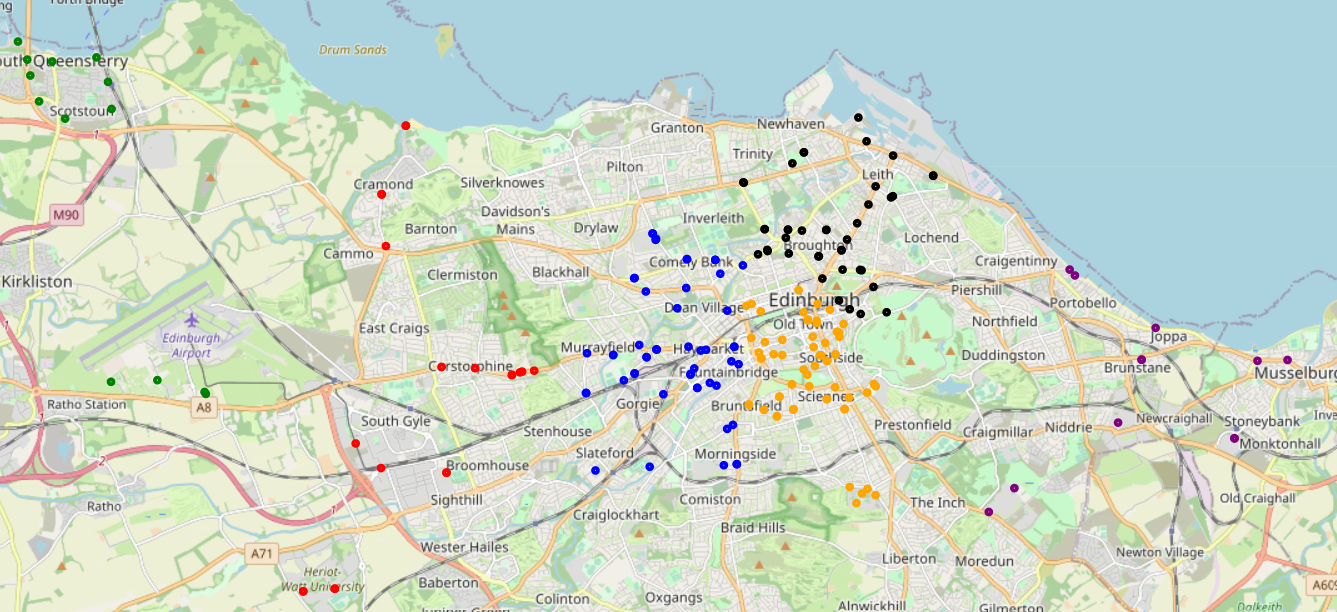

In [37]:
#m

### Distances between stations

Below we calculated distances between each stations. <br/>
We get distances from 0 km to 22 km. We are going to assume that the 0 distances are stations that are very close to each other. Average distance between stations is 4,8 km and median is 3,5 km. The third quartile is 6,8 km so we coud say that most of the stations are in range of 7 km from each other and the maximum is more of a exception.

In [38]:
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) #2*R*asin...

In [39]:
df_distance = df[["start_station_id","start_station_latitude","start_station_longitude"]].drop_duplicates(subset='start_station_id').reset_index(drop=True)
df_distance = df_distance.merge(right=df_distance,how='cross')
df_distance = df_distance.drop(df_distance[df_distance['start_station_id_x'] == df_distance['start_station_id_y']].index)

In [40]:
dinstance_lst = []
for i in range(len(df_distance.index)):
    dinstance_lst.append(round(distance(df_distance["start_station_latitude_x"].iloc[i],df_distance["start_station_longitude_x"].iloc[i],
                                        df_distance["start_station_latitude_y"].iloc[i],df_distance["start_station_longitude_y"].iloc[i]),3))
    
df_distance['distance'] = dinstance_lst

In [41]:
df_distance['distance'].describe()

count    39006.000
mean         4.838
std          3.835
min          0.000
25%          2.013
50%          3.517
75%          6.825
max         22.370
Name: distance, dtype: float64

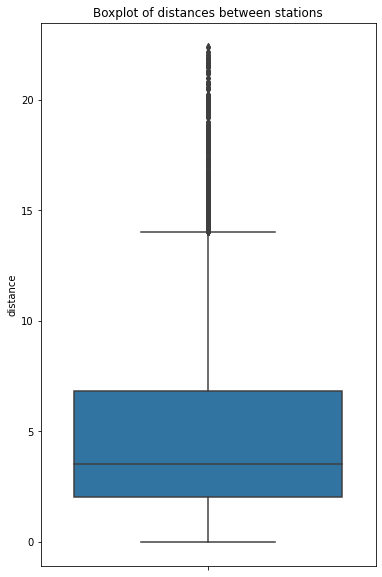

In [42]:
plt_box_dist = sns.boxplot(y=df_distance['distance'])
plt_box_dist.set_title('Boxplot of distances between stations')
plt_box_dist.figure.set_size_inches(6, 10);

In [43]:
df_distance.sort_values(by='distance',ascending=False).head(10)

start_station_id_x  start_station_latitude_x  \
39000                2265                    55.944   
38212                1877                    55.993   
38995                2265                    55.944   
37222                1869                    55.990   
37420                1868                    55.988   
38996                2265                    55.944   
38211                1877                    55.993   
38802                2263                    55.944   
38122                1877                    55.993   
21180                1033                    55.932   

       start_station_longitude_x  start_station_id_y  \
39000                     -3.058                1877   
38212                     -3.407                2265   
38995                     -3.058                1869   
37222                     -3.405                2265   
37420                     -3.404                2265   
38996                     -3.058                1868   
38211                     -3.407                2263   
38802                     -3.067                1877   
38122                     -3.407                1033   
21180                     -3.073                1877   

       start_station_latitude_y  start_station_longitude_y  distance  
39000                    55.993                     -3.407    22.370  
38212                    55.944                     -3.058    22.370  
38995                    55.990                     -3.405    22.143  
37222                    55.944                     -3.058    22.143  
37420                    55.944                     -3.058    22.030  
38996                    55.988                     -3.404    22.030  
38211                    55.944                     -3.067    21.875  
38802                    55.993                     -3.407    21.875  
38122                    55.932                     -3.073    21.874  
21180                    55.993                     -3.407    21.874

In [44]:
df_distance.sort_values(by='distance').head(10)

start_station_id_x  start_station_latitude_x  \
12435                 866                    55.959   
31544                1763                    55.959   
11013                 366                    55.976   
12210                 862                    55.980   
26197                1722                    55.980   
28762                1744                    55.928   
10441                 346                    55.928   
7239                  341                    55.938   
24409                1095                    55.976   
22014                1051                    55.938   

       start_station_longitude_x  start_station_id_y  \
12435                     -3.216                1763   
31544                     -3.216                 866   
11013                     -3.191                1095   
12210                     -3.301                1722   
26197                     -3.301                 862   
28762                     -3.210                 346   
10441                     -3.210                1744   
7239                      -3.198                1051   
24409                     -3.191                 366   
22014                     -3.198                 341   

       start_station_latitude_y  start_station_longitude_y  distance  
12435                    55.959                     -3.216     0.000  
31544                    55.959                     -3.216     0.000  
11013                    55.976                     -3.191     0.001  
12210                    55.980                     -3.301     0.001  
26197                    55.980                     -3.301     0.001  
28762                    55.928                     -3.210     0.001  
10441                    55.928                     -3.210     0.001  
7239                     55.938                     -3.198     0.001  
24409                    55.976                     -3.191     0.001  
22014                    55.938                     -3.198     0.001

#### Distribution of distances

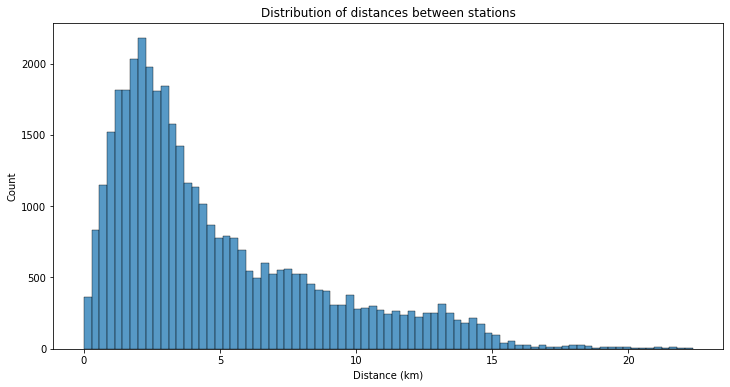

In [45]:
plt_distance =sns.histplot(data=df_distance['distance'])
plt_distance.set_xlabel("Distance (km)")
plt_distance.set_title('Distribution of distances between stations')
plt_distance.figure.set_size_inches(12, 6);

### Duration of bikes rent<br>
After converting duration variable to minutes we explore data with basic descriptive statistics a plot data with box plot. Average duration is 32 minutes and median value is 19 minutes. Maximum value is 39389 minutes that would be aproximately 656 hours and minimum duration is 1 minute. That indicate there are some outliers we should deal with.

In [46]:
# Convert duration to minutes
duration = df["duration"]/60

In [47]:
duration.describe()

count    437096.000
mean         32.488
std          94.384
min           1.017
25%          10.400
50%          19.400
75%          42.150
max       39389.133
Name: duration, dtype: float64

Just quickly ploting data to box plot we can see that there are definitely some extreme values that we should clean.

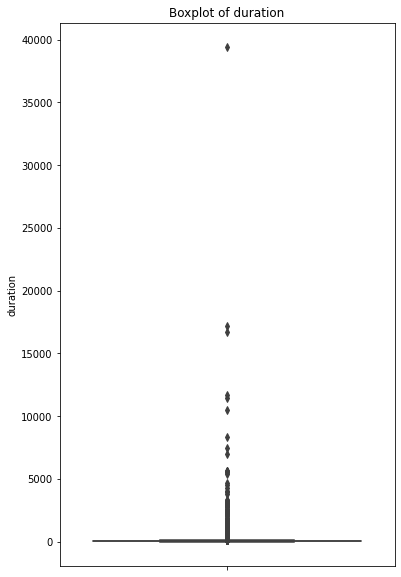

In [48]:
plt_box_duration = sns.boxplot(y=duration)
plt_box_duration.set_title('Boxplot of duration')
plt_box_duration.figure.set_size_inches(6, 10);

We are going to assume that records with **duration greater then 24 hours** were due to some issue with returning bike or something similar. In the same way we are going to assume that **duration lesser than 2 minutes** are due to some system issue and does not give us valuable informations.

In [49]:
# Drop records that have duration of trip less than 2 minutes and more than 24 hours
duration_less_than_2minutes = duration < 2
duration_more_than_24hours = duration > 1440 
duration = duration[~(duration_less_than_2minutes) & ~(duration_more_than_24hours)]

Now it is looking little bit better.

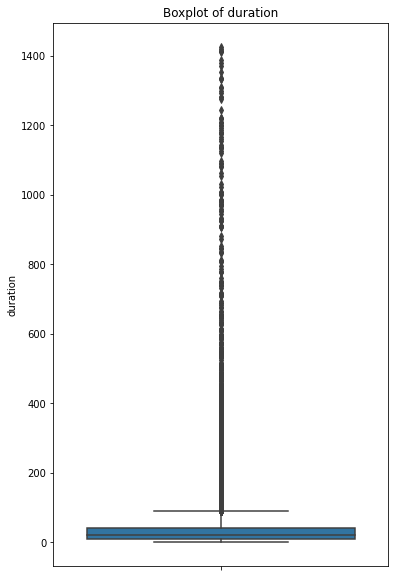

In [50]:
plt_box_duration = sns.boxplot(y=duration)
plt_box_duration.set_title('Boxplot of duration')
plt_box_duration.figure.set_size_inches(6, 10);

Next we generate histogram of duration times. The distribution is not looking like normaly distributed. It is highly skeewed to the right. That means that we have a some more outliers or the distribution is not normal. A skewed shape as we got is typical of a log-normal distribution.

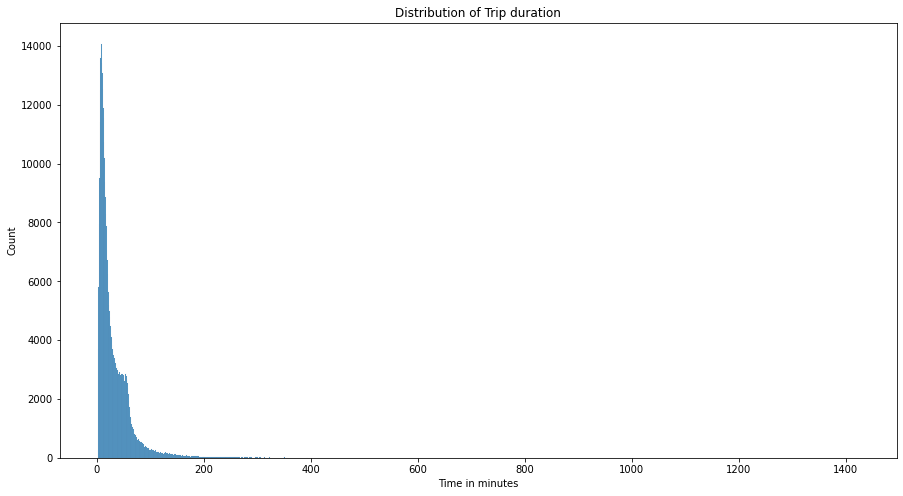

In [51]:
plt_duration =sns.histplot(data=duration)
plt_duration.set_xlabel("Time in minutes")
plt_duration.set_title("Distribution of Trip duration")
plt_duration.figure.set_size_inches(15, 8);

To check if the duration distribution is following **log-normal distribution** we take the log of each of our duration data points and plot the to histogram again. And we can se that know the distribution is looking much more like a normal distribution even if its not perfect.

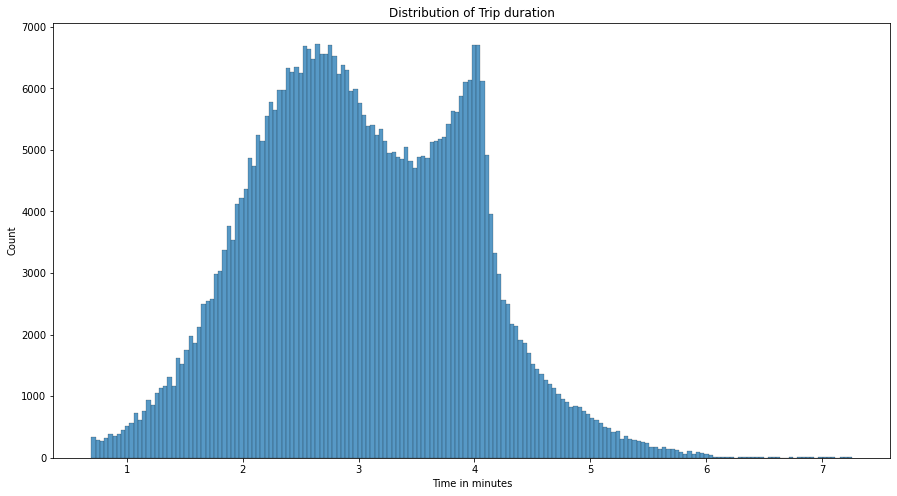

In [52]:
duration_log = np.log(duration)
plt_duration_log =sns.histplot(data=duration_log)
plt_duration_log.set_xlabel("Time in minutes")
plt_duration_log.set_title("Distribution of Trip duration")
plt_duration_log.figure.set_size_inches(15, 8);

In [53]:
duration_log.describe()

count    433349.000
mean          3.034
std           0.917
min           0.693
25%           2.359
50%           2.976
75%           3.747
max           7.261
Name: duration, dtype: float64

## Demand analysis
Demand analysis:
<ul>
<li>Visualize demand for bike renting through time.
<li>Identify causes of demand fluctuation.
<li>Determine possible influence of weather on bike renting
<li>Determine if demand for bike renting is higher on weekdays of weekends.

### Demand throught months and years

In [54]:
def DateTimeCount(df, offset_alias):
    df_temp = df.copy()
    df_temp.set_index("started_at",inplace=True)
    df_temp = df_temp["ended_at"].resample(offset_alias).agg("count").reset_index().rename(columns={"ended_at":"cnt"})
    return df_temp

Firstly we plot data grouped to periods of month and years. **The heighest demand was in period from 05-2020 to 10-2020.**

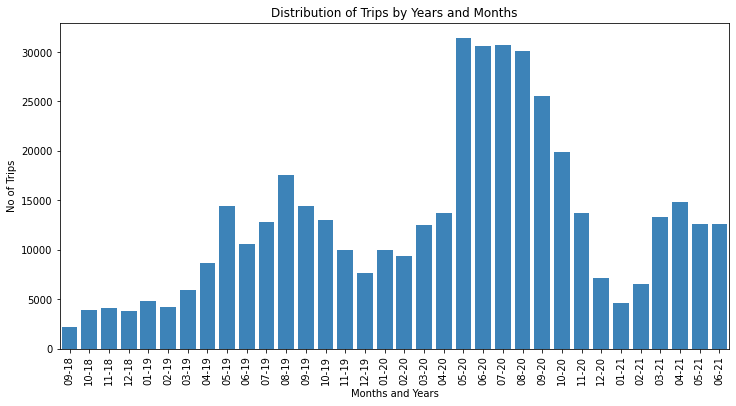

In [55]:
df_year_month = DateTimeCount(df,"M")
df_year_month["started_at"] = df_year_month["started_at"].dt.strftime("%m-%y")

plt_year_month = sns.barplot(x="started_at", y="cnt", data=df_year_month,color="#2986CC")
plt_year_month.set_xlabel("Months and Years")
plt_year_month.set_ylabel("No of Trips")
plt_year_month.set_title("Distribution of Trips by Years and Months")
plt_year_month.tick_params(axis='x', rotation=90)
plt_year_month.figure.set_size_inches(12, 6);

### Demand through individual months
As expected the highest demand in terms of month is in the warmer months. May and June had the highest demand overall. And in the colder month the lowest demand was in January, February and December. 

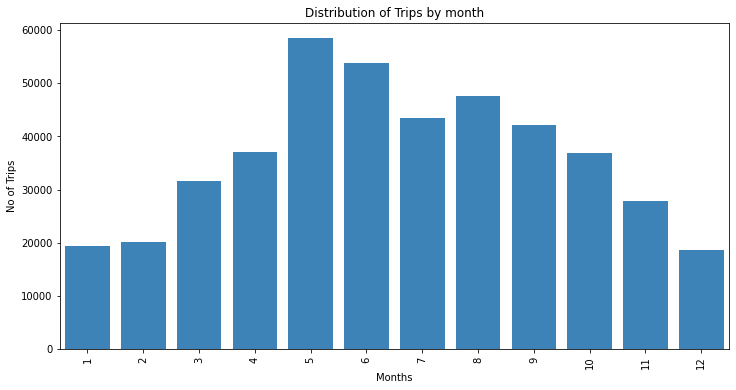

In [56]:
# Demand in months 
df_month = DateTimeCount(df,'M')
df_month = df_month.groupby(df_month["started_at"].dt.month).sum().reset_index()

plt_month = sns.barplot(x="started_at", y="cnt", data=df_month,color="#2986CC")
plt_month.set_xlabel("Months")
plt_month.set_ylabel("No of Trips")
plt_month.set_title("Distribution of Trips by month")
plt_month.tick_params(axis="x", rotation=90)
plt_month.figure.set_size_inches(12, 6);

### Demand through weeks
In terms of calendar weeks the single highest demand was in 22nd week which end of the May and start of the June.

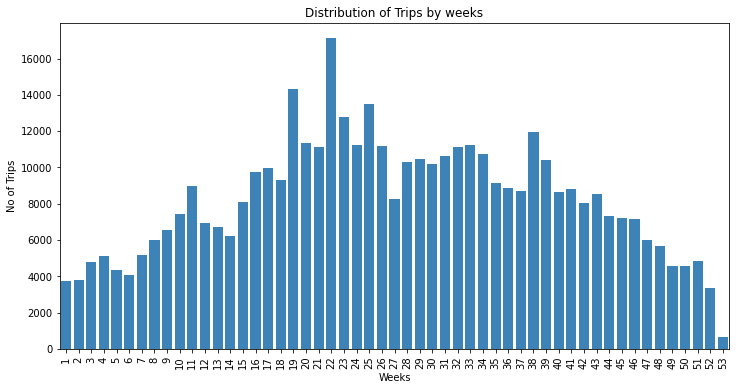

In [57]:
# Demand in calender weeks
df_weeks = DateTimeCount(df,'W')
df_weeks = df_weeks.groupby(df_weeks["started_at"].dt.isocalendar().week).sum().reset_index()

plt_weeks = sns.barplot(x="week", y="cnt", data=df_weeks,color="#2986CC")
plt_weeks.set_xlabel("Weeks")
plt_weeks.set_ylabel("No of Trips")
plt_weeks.set_title("Distribution of Trips by weeks")
plt_weeks.tick_params(axis="x", rotation=90)
plt_weeks.figure.set_size_inches(12, 6);

### Demand through days of the year
If we plot single days we can see big spikes in usage sometime during May and June of 2020. To further investigate the cause  we would have to find out if there was some special event during this time, but that is outside of scope of this project.

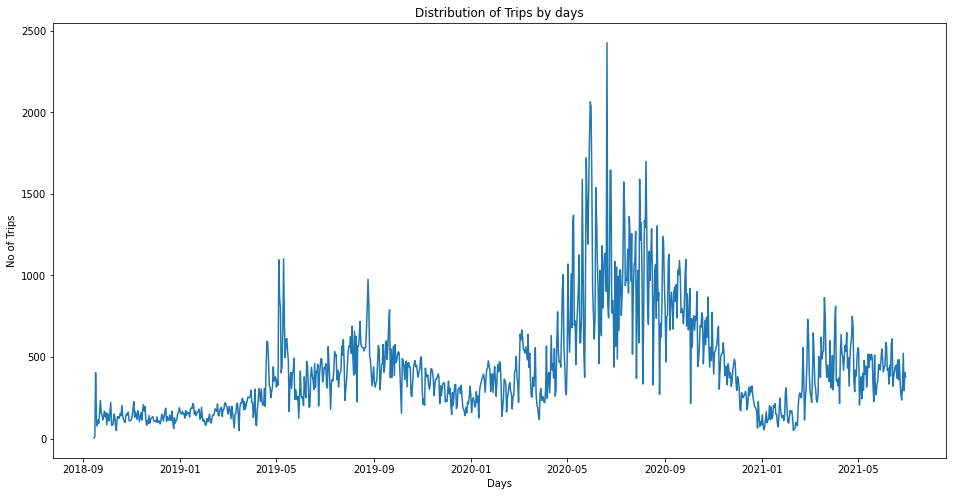

In [58]:
# Demand in calender days
df_days_year = DateTimeCount(df,'D')

plt_days_year =sns.lineplot(x="started_at", y="cnt",data=df_days_year)
plt_days_year.set_xlabel("Days")
plt_days_year.set_ylabel("No of Trips")
plt_days_year.set_title("Distribution of Trips by days")

plt_days_year.figure.set_size_inches(16, 8);

In regard to above chart we could just quickly sort values and look that the big spikes are from 30-31.05.2020 and 6.6.2020. That would be last weekend in may and first weekend in june. Deeper research could tell us if Edinburgh has some special event or if it correlate with some covid-19 restriction uplifting. 

In [59]:
df_days_year.sort_values(by="cnt",ascending=False).head(10)

started_at   cnt
644 2020-06-20  2428
623 2020-05-30  2065
624 2020-05-31  2036
622 2020-05-29  1832
618 2020-05-25  1721
693 2020-08-08  1700
648 2020-06-24  1646
649 2020-06-25  1644
685 2020-07-31  1591
613 2020-05-20  1589

### Demand through days of the week
Lowest demand is on monday and highest demand is on the weekends. Specifically saturday has highest demand from all week.

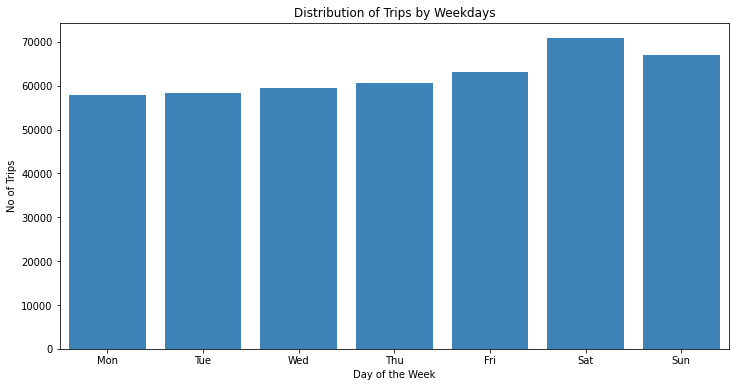

In [60]:
# Demand in days of the week
df_days = DateTimeCount(df,"D")
df_days = df_days.groupby(df_days["started_at"].dt.day_of_week).sum().reset_index()

plt_days = sns.barplot(x="started_at", y="cnt", data=df_days,color="#2986CC")
plt_days.set_xlabel("Day of the Week")
plt_days.set_ylabel("No of Trips")
plt_days.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt_days.set_title("Distribution of Trips by Weekdays")
plt_days.figure.set_size_inches(12, 6);

#### Demand thought day

We can see that greatest demand was in the afternoon hours around 16 o'clock and as expected lowest demand was in early morning hours from midnight to around 5-6 o'clock in the morning.

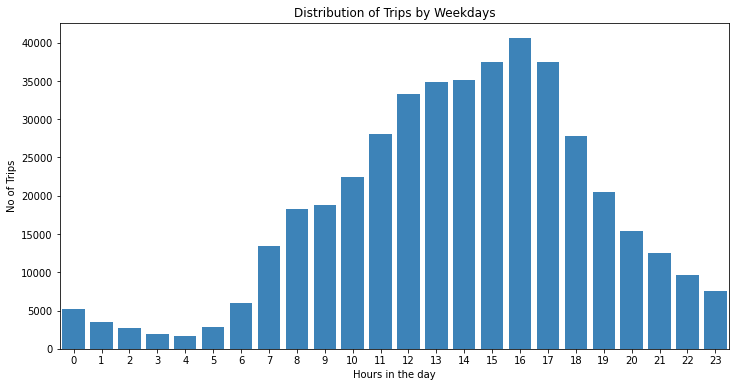

In [61]:
df_hours = DateTimeCount(df,'H')
df_hours = df_hours.groupby(df_hours['started_at'].dt.hour).sum().reset_index()

plt_hours = sns.barplot(x="started_at", y="cnt", data=df_hours,color="#2986CC")
plt_hours.set_xlabel("Hours in the day")
plt_hours.set_ylabel("No of Trips")
plt_hours.set_title("Distribution of Trips by Weekdays")
plt_hours.figure.set_size_inches(12, 6);

### Weather influence on bikes demand
After displaying dataframe with weather information we see that some columns are going to be needed to clean up. In order to work with variables further they have to be numerical. So we need to get rid of the text from individual columns.

In [62]:
df_weather

time   temp  feels              wind     gust    rain humidity cloud  \
0     00:00  11 °c  11 °c     9 km/h from S  19 km/h  0.0 mm      79%   13%   
1     03:00  13 °c  12 °c  11 km/h from SSW  19 km/h  0.0 mm      76%   96%   
2     06:00  14 °c  13 °c  11 km/h from SSW  19 km/h  0.0 mm      84%  100%   
3     09:00  14 °c  13 °c  14 km/h from SSW  23 km/h  0.1 mm      88%   78%   
4     12:00  16 °c  16 °c  15 km/h from SSW  22 km/h  0.0 mm      87%   87%   
...     ...    ...    ...               ...      ...     ...      ...   ...   
6331  09:00  14 °c  12 °c  21 km/h from SSE  33 km/h  0.4 mm      86%  100%   
6332  12:00  14 °c  12 °c  24 km/h from SSE  37 km/h  0.4 mm      88%   94%   
6333  15:00  10 °c   6 °c   42 km/h from SW  55 km/h  0.5 mm      75%  100%   
6334  18:00   9 °c   5 °c  38 km/h from WSW  54 km/h  0.0 mm      76%   79%   
6335  21:00   8 °c   4 °c   36 km/h from SW  49 km/h  0.1 mm      74%   79%   

     pressure        vis       date  
0     1020 mb  Excellent 2018-09-01  
1     1020 mb  Excellent 2018-09-01  
2     1020 mb  Excellent 2018-09-01  
3     1021 mb  Excellent 2018-09-01  
4     1021 mb  Excellent 2018-09-01  
...       ...        ...        ...  
6331   993 mb       Poor 2020-10-31  
6332   987 mb       Poor 2020-10-31  
6333   989 mb  Excellent 2020-10-31  
6334   994 mb  Excellent 2020-10-31  
6335   997 mb  Excellent 2020-10-31  

[6336 rows x 11 columns]

In [63]:
# Clean columns with text values and convert them to int
for col in df_weather.columns:
    if col not in ["time","vis","date"]:
        df_weather[col] = df_weather[col].str.replace(r'\D', '',regex=True).astype(int)

In [64]:
# Quick look on data after the cleanup
df_weather.head(10)

time  temp  feels  wind  gust  rain  humidity  cloud  pressure        vis  \
0  00:00    11     11     9    19     0        79     13      1020  Excellent   
1  03:00    13     12    11    19     0        76     96      1020  Excellent   
2  06:00    14     13    11    19     0        84    100      1020  Excellent   
3  09:00    14     13    14    23     1        88     78      1021  Excellent   
4  12:00    16     16    15    22     0        87     87      1021  Excellent   
5  15:00    17     17    14    21     0        83     97      1021  Excellent   
6  18:00    16     16    12    19     0        88     98      1022  Excellent   
7  21:00    14     14    11    19     0        94     52      1022  Excellent   
8  00:00    13     13    10    19     0        95     31      1022       Poor   
9  03:00    13     13     8    15     0        96     52      1020       Poor   

        date  
0 2018-09-01  
1 2018-09-01  
2 2018-09-01  
3 2018-09-01  
4 2018-09-01  
5 2018-09-01  
6 2018-09-01  
7 2018-09-01  
8 2018-09-02  
9 2018-09-02

Now we are going to merge the weather data with the bike sharing data

In [65]:
df_bikes_days = DateTimeCount(df,'D')
df_bikes_weather = df_bikes_days.merge(right=df_weather,how="inner",left_on="started_at",right_on="date")
df_weather_agg = df_bikes_weather.groupby(["started_at","cnt"]).agg("mean").reset_index()
df_weather_agg

started_at  cnt    temp   feels    wind    gust    rain  humidity   cloud  \
0   2018-09-15    3  10.500   8.500  14.875  23.500   1.250    83.875  58.125   
1   2018-09-16   10  12.875  10.625  26.500  43.125   1.250    81.500  79.500   
2   2018-09-17  403  13.875  13.125  18.000  29.875   0.250    83.000  66.125   
3   2018-09-18  126  14.125  13.500  16.875  28.500   2.375    86.875  57.750   
4   2018-09-19   77  11.750   8.625  34.750  55.625   3.625    75.750  52.250   
..         ...  ...     ...     ...     ...     ...     ...       ...     ...   
773 2020-10-27  437   7.125   4.625  15.250  22.375   1.250    86.250  54.125   
774 2020-10-28  559   7.250   3.500  24.500  34.000   1.500    83.625  87.500   
775 2020-10-29  478   6.750   5.250  16.875  26.625  12.625    87.500  84.625   
776 2020-10-30  774  10.500   8.125  20.500  28.625   0.875    78.625  62.375   
777 2020-10-31  523  10.125   7.250  26.000  37.500   3.500    80.750  82.875   

     pressure  
0    1017.375  
1    1008.875  
2    1006.375  
3     996.125  
4     995.875  
..        ...  
773   988.625  
774   990.125  
775   999.000  
776  1006.875  
777   997.375  

[778 rows x 10 columns]

Plot merged data to pairplot to see if there are some correlation between weather and frequency of bike renting. Visual charts are not giving us conclusive information if there are correlation.

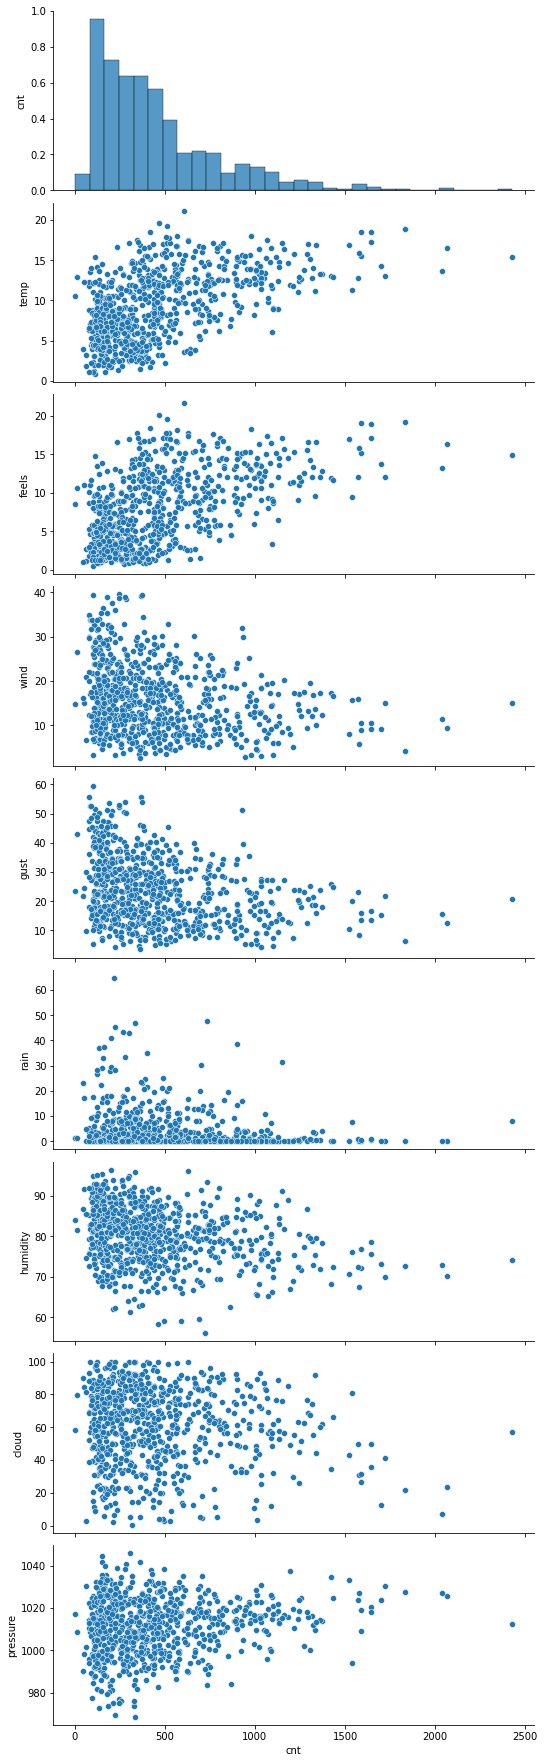

In [66]:
pplot = sns.pairplot(df_weather_agg,x_vars="cnt")
pplot.fig.set_size_inches(10,25);

Correlation matrix give us better sense of possible relationship between variables. Quite moderate correlation seems to be between temprature and 'feels like' temperature. Correlation coeficients are 0,53 for temperature and 0,56 for feel like temperature. But outside of that we did't get any strong evidence of correlation between weather and how much people rent bikes.

In [67]:
corr = df_weather_agg.corr()
corr.style.background_gradient(cmap='coolwarm')

Below we plot the teperature data and number of bikes rented. And as we pointed out above there are faily moderate correlation. 

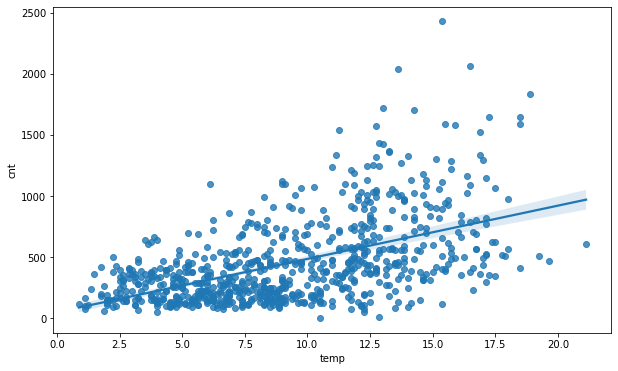

In [68]:
plt_reg  = sns.regplot(x="temp", y="cnt", data=df_weather_agg)
plt_reg.figure.set_size_inches(10, 6);

The same is true for feels like temperature and number of rented bikes. Here is the correlation even a bit higher. 

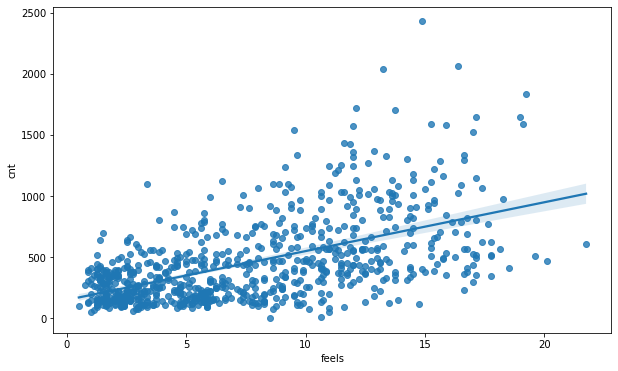

In [69]:
plt_reg  = sns.regplot(x="feels", y="cnt", data=df_weather_agg)
plt_reg.figure.set_size_inches(10, 6);